In [ ]:
catchment_name  = 'WykeBeck'

In [3]:
import sys
import os
import folium
import numpy.ma as ma
from folium import Map, FeatureGroup, LayerControl
import rasterio
from shapely.geometry import box
import geopandas as gpd
from pyproj import CRS
from rasterio.mask import mask
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import rioxarray as rxr
from rasterio import plot
from shapely.geometry import mapping
import glob 

# Define whether to filter out values <0.1
remove_little_values = True

sys.path.append("../ProcessModelResults/")
from my_functions import *

# Specify strings relating to catchment
if catchment_name == 'LinDyke':
    minx, miny, maxx, maxy = 437000,  426500,  445500, 434300
elif catchment_name == 'WykeBeck':
    minx, miny, maxx, maxy = 430004,  429978, 438660, 440996 
    
# Create a bounding box (this is used in preparing the rasters)
bbox = box(minx, miny, maxx, maxy)    

model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)

subcatchments = False

### Read in main catchment boundary and add to boundaries dictionary

In [37]:
if catchment_name == 'LinDyke':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
elif catchment_name == 'WykeBeck':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))
    
# Add to dictionary    
boundaries_gpd_dict={}
boundaries_gpd_dict[catchment_name] =catchment_gdf

### Add subcatchment boundaries, if using

In [39]:
if subcatchments == True:
    for subcatchment in ['Garforth_East', 'Garforth_West', 'Kippax_West', 'South_Catchment', 'Kippax','Garforth', 'TB_South', 'TB_North']:
        # Read in boundary
        boundary = gpd.read_file(model_directory + "SubCatchmentBoundaries/{}/{}.shp".format(subcatchment, subcatchment))
        # Convert projection
        boundary = boundary.to_crs("epsg:27700") 
        # Add to dict
        boundaries_gpd_dict[subcatchment]=boundary

### Read in watercourses data

In [5]:
watercourses = gpd.read_file('../../../FloodModelling/ExtraData/Watercourses/WatercourseLink.shp')
watercourses_clip = gpd.clip(watercourses, catchment_gdf)

In [ ]:
GB_Boundary = gpd.read_file('../../../FloodModelling/ExtraData/GB_Boundary/infuse_uk_2011.shp')
GB_Boundary = GB_Boundary.to_crs("epsg:27700") 

### Read in the land cover file, clip it, update some parameters, save to landcover directory 

In [64]:
if catchment_name == 'LinDyke':
    original_landcover_fp = "LandCover_resized"
elif catchment_name == 'WykeBeck':
    original_landcover_fp = "LandCover_resized"

if not os.path.isfile(model_directory + 'LandCoverData/LandCover_clipped.tif'):
    landcover_clipped, out_meta = open_and_clip(model_directory + 'LandCoverData/{}.tif'.format(original_landcover_fp), bbox)
    out_meta.update({"nodata":np.nan, "dtype" :'float64' })
    landcover_clipped[landcover_clipped == -2147483648] = np.nan
    save_array_as_raster(landcover_clipped, model_directory + 'LandCoverData/LandCover_clipped.tif', out_meta)
else:
    landcover_clipped, out_meta = open_and_clip( model_directory + 'LandCoverData/LandCover_clipped.tif', bbox)

### Create a modified version of the data with flag for urban (10) -including urban and suburban - and non-urban (11),  save to landcover directory

In [66]:
if not os.path.isfile(model_directory + 'LandCoverData/LandCover_urban_classification.tif'):
    # Convert the 1 and 6 values to 10 (for urban) and the rest to 11 (for non-urban).  
    landcover_mod =  np.where(landcover_clipped==1, 10, landcover_clipped)
    landcover_mod =  np.where(landcover_mod==6, 10, landcover_mod)
    # Convert the rest of the classes to 11
    for i in [2,3,4,5,7,8,9]:
        landcover_mod =  np.where(landcover_mod==i, 11, landcover_mod)
    save_array_as_raster(landcover_mod, model_directory + 'LandCoverData/LandCover_urban_classification.tif', out_meta)
else:
    landcover_mod, out_meta = open_and_clip(model_directory + '/LandCoverData/LandCover_urban_classification.tif', bbox)

### Create a modified version of the data with flag for urban (10) and non-urban (11), save to landcover directory

In [67]:
if not os.path.isfile(model_directory + 'LandCoverData/LandCover_urban_classification2.tif'):
    # Convert the 1 to 10 (for urban) and the rest to 11 (for non-urban).  
    landcover_mod2 =  np.where(landcover_clipped==6, 10, landcover_clipped)
    # Convert the rest of the classes to 11
    for i in [1,2,3,4,5,7,8,9]:
        landcover_mod2 =  np.where(landcover_mod2==i, 11, landcover_mod2)
    save_array_as_raster(landcover_mod2, model_directory + 'LandCoverData/LandCover_urban_classification2.tif', out_meta)
else:
    landcover_mod2, out_meta = open_and_clip(model_directory + 'LandCoverData/LandCover_urban_classification2.tif', bbox)

### Create a modified version with flag for water and nothing else

In [68]:
if not os.path.isfile(model_directory + 'LandCoverData/LandCover_water_classification.tif'):
    # Convert the 3 to 10 (for water) and the rest to 11 (for non-water).  
    landcover_water =  np.where(landcover_clipped==4, 10, landcover_clipped)
    # Convert the rest of the classes to 11
    for i in [1,2,3,5,6,7,8,9]:
        landcover_water =  np.where(landcover_water==i, 11, landcover_water)
    save_array_as_raster(landcover_water, model_directory + 'LandCoverData/LandCover_water_classification.tif', out_meta)

#### Count the number of cells in each of the categories

In [50]:
values, counts = np.unique(landcover_mod2, return_counts=True)
df=pd.DataFrame({'values':values,'WholeCatchment': counts})

### Plot - both original landcover data and classified urban/not urban data

In [51]:
cols_dict = {}
cols = ['black','green', 'orange','purple','yellow','blue','cyan','pink', 'darkgreen']
for num,key in enumerate(boundaries_gpd_dict.keys()):
    cols_dict[key] =cols[num]

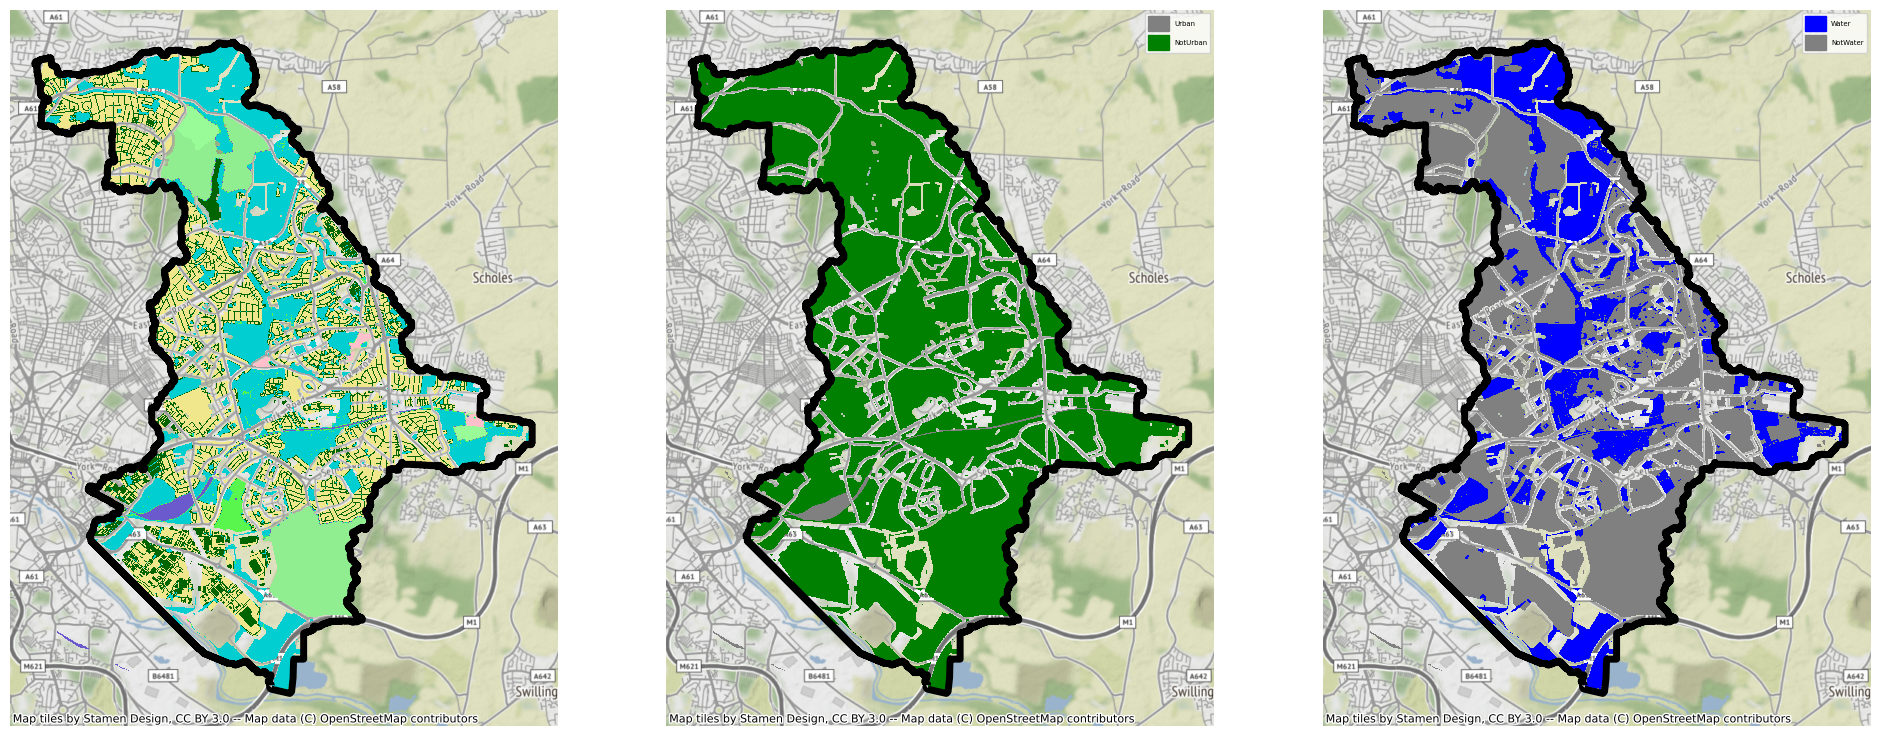

In [52]:
clipped = rasterio.open(model_directory + 'LandCoverData/LandCover_clipped.tif')
labels= ['SubUrban', 'Arable', 'Deciduous woodland', 'Freshwater', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland']
colors = ['darkslategrey', 'khaki', 'darkgreen','darkturquoise','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink']
cmap = mpl.colors.ListedColormap(colors)

water_classified = rasterio.open(model_directory + 'LandCoverData/LandCover_water_classification.tif')
labels_water = [ 'Water','NotWater']
colors_water = ['blue', 'grey']
cmap_water = mpl.colors.ListedColormap(colors_water)

urban_classified = rasterio.open(model_directory + 'LandCoverData/LandCover_urban_classification.tif')
labels_urban = ['Urban', 'NotUrban']
colors_urban = ['grey', 'green']
cmap_urban = mpl.colors.ListedColormap(colors_urban)

fig, axs = plt.subplots(ncols = 3, figsize=(24, 10))

for boundary_key, boundary in boundaries_gpd_dict.items():
    boundary.plot(ax=axs[0], facecolor="none", linewidth=5, edgecolor =cols_dict[boundary_key])
cx.add_basemap(axs[0], crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
plot.show((clipped, 1), ax= axs[0], cmap=cmap)

for boundary_key, boundary in boundaries_gpd_dict.items():
    boundary.plot(ax=axs[1], facecolor="none", linewidth=5, edgecolor =cols_dict[boundary_key])
cx.add_basemap(axs[1], crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
plot.show((urban_classified, 1), ax= axs[1], cmap=cmap_urban)

for boundary_key, boundary in boundaries_gpd_dict.items():
    boundary.plot(ax=axs[2], facecolor="none", linewidth=5, edgecolor =cols_dict[boundary_key])
cx.add_basemap(axs[2], crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
plot.show((water_classified, 1), ax= axs[2], cmap=cmap_water)

# Create patches for legend
patches_list = []
for i, color in  enumerate(colors):
    patch =  mpatches.Patch(color=color, label=labels[i])
    patches_list.append(patch)  
    
patches_list_water = []
for i, color in  enumerate(colors_water):
    patch =  mpatches.Patch(color=color, label=labels_water[i])
    patches_list_water.append(patch)      
    
patches_list_urban = []
for i, color in  enumerate(colors_urban):
    patch =  mpatches.Patch(color=color, label=labels_urban[i])
    patches_list_urban.append(patch)      

# Close file (otherwise can't delete it, as ref to it is open)
# clipped.close()
# classified.close()
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
# axs[0].legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =5);
axs[1].legend(handles=patches_list_urban, handleheight=3, handlelength=3, fontsize =5);
axs[2].legend(handles=patches_list_water, handleheight=3, handlelength=3, fontsize =5);

### Create catchment bounding box (for plotting on map of UK?)

In [54]:
bounds =np.array([437105.2274562499, 445746.48466874973, 426332.93763125024, 434380.81249375])
# bounds = catchment_gdf.total_bounds
from shapely.geometry import box
country_box = box(*bounds)
buffered_box = country_box.buffer(1.4)
gdf = gpd.GeoDataFrame(index=[0], crs='epsg:27700', geometry=[country_box])

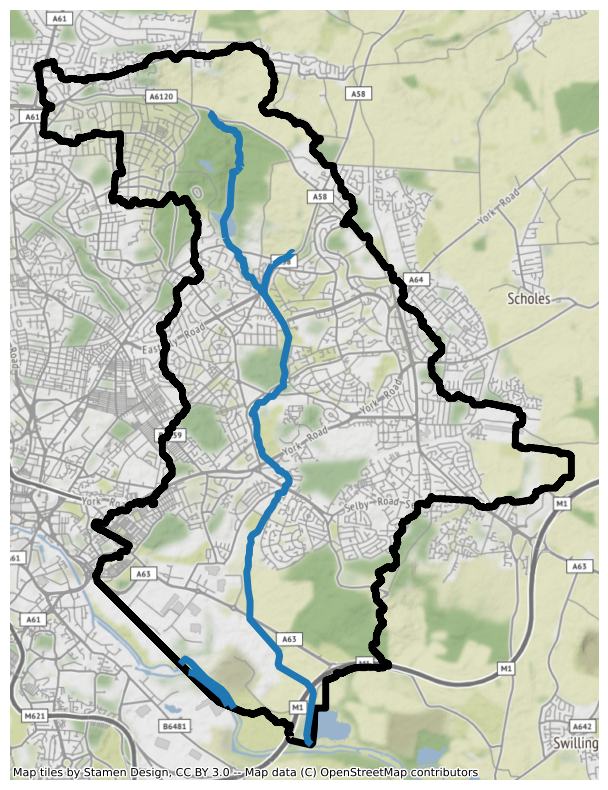

In [57]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(24, 10))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
# left, bottom, width, height = [0.8, 0.6, 0.2, 0.1]
# ax2 = fig.add_axes([left, bottom, width, height])

# GB_Boundary.plot(ax=ax2, facecolor="white", linewidth=2, edgecolor ='black')
# gdf.plot(ax=ax2, facecolor="none", linewidth=2, edgecolor ='red')
# ax2.axis('off');

catchment_gdf.plot(ax=ax1, facecolor="none", linewidth=5, edgecolor ='black')
watercourses_clip.plot(ax=ax1, linewidth=5)    
cx.add_basemap(ax1, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenTopoMap, zoom=13)
ax1.axis('off');
plt.show()

### Plot the bounding box of catchment on map of UK

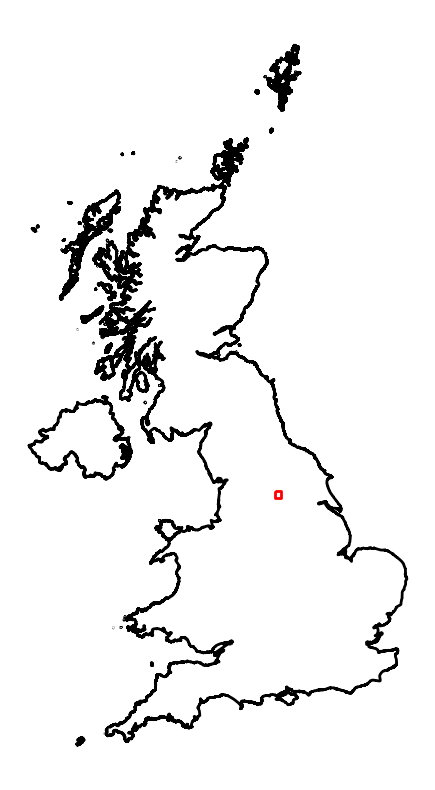

In [61]:
fig, ax = plt.subplots(figsize=(24, 10))
GB_Boundary.plot(ax=ax, facecolor="none", linewidth=2, edgecolor ='black')
gdf.plot(ax=ax, facecolor="none", linewidth=2, edgecolor ='red')
ax.axis('off');

### Plot catchment boundary, and main water course

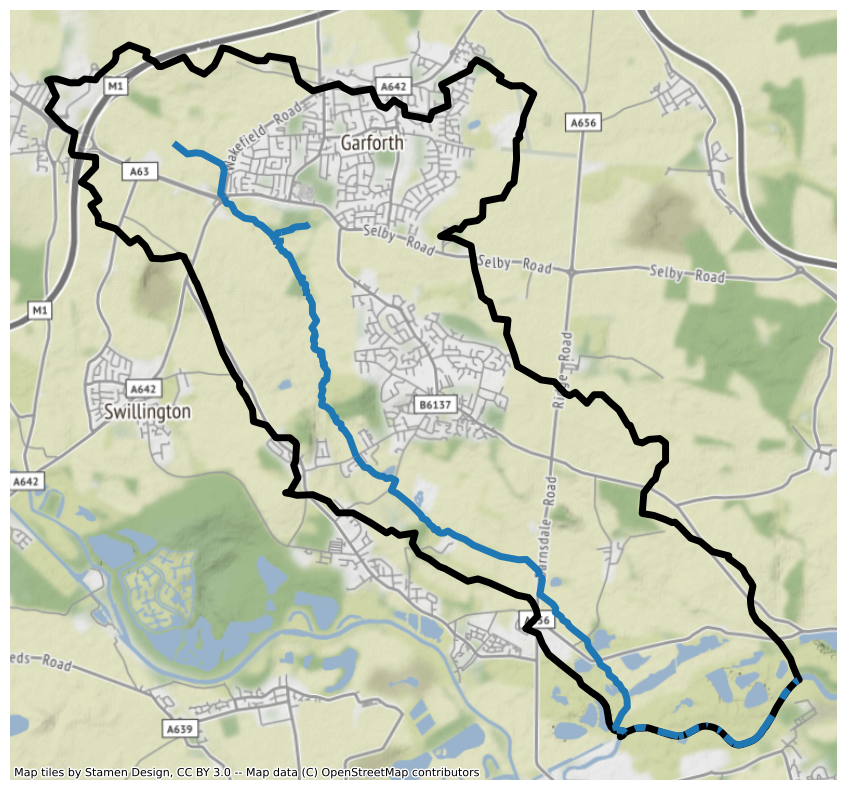

In [33]:
fig, ax = plt.subplots(figsize=(24, 10))
catchment_gdf.plot(ax=ax, facecolor="none", linewidth=5, edgecolor ='black')
watercourses_clip.plot(ax=ax, linewidth=5)    
cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenTopoMap, zoom=13)
ax.axis('off');

In [1]:
from mpl_toolkits.basemap import Basemap

In [36]:
# fig, ax = plt.subplots(figsize=(10,10))
# m = Basemap(llcrnrlon=-7.5600,llcrnrlat=49.7600,
#             urcrnrlon=2.7800,urcrnrlat=60.840,
#             resolution='l',
#             projection='tmerc',
#             lon_0=-4.36,lat_0=54.7,
#             epsg=27700)
# catchment_gdf.plot(ax=ax, facecolor="none", linewidth=5, edgecolor ='black')

# m.drawmapboundary(fill_color='white')
# m.fillcontinents(color='white',lake_color='white') #zorder=0
# m.drawcoastlines()
# # m.drawrivers(linewidth=2, color='#46bcec')
# m.drawcountries()

In [25]:
bounds = catchment_gdf.total_bounds
from shapely.geometry import box
country_box = box(*bounds)
buffered_box = country_box.buffer(1.4)

### Plot with folium (to check covering the right area)


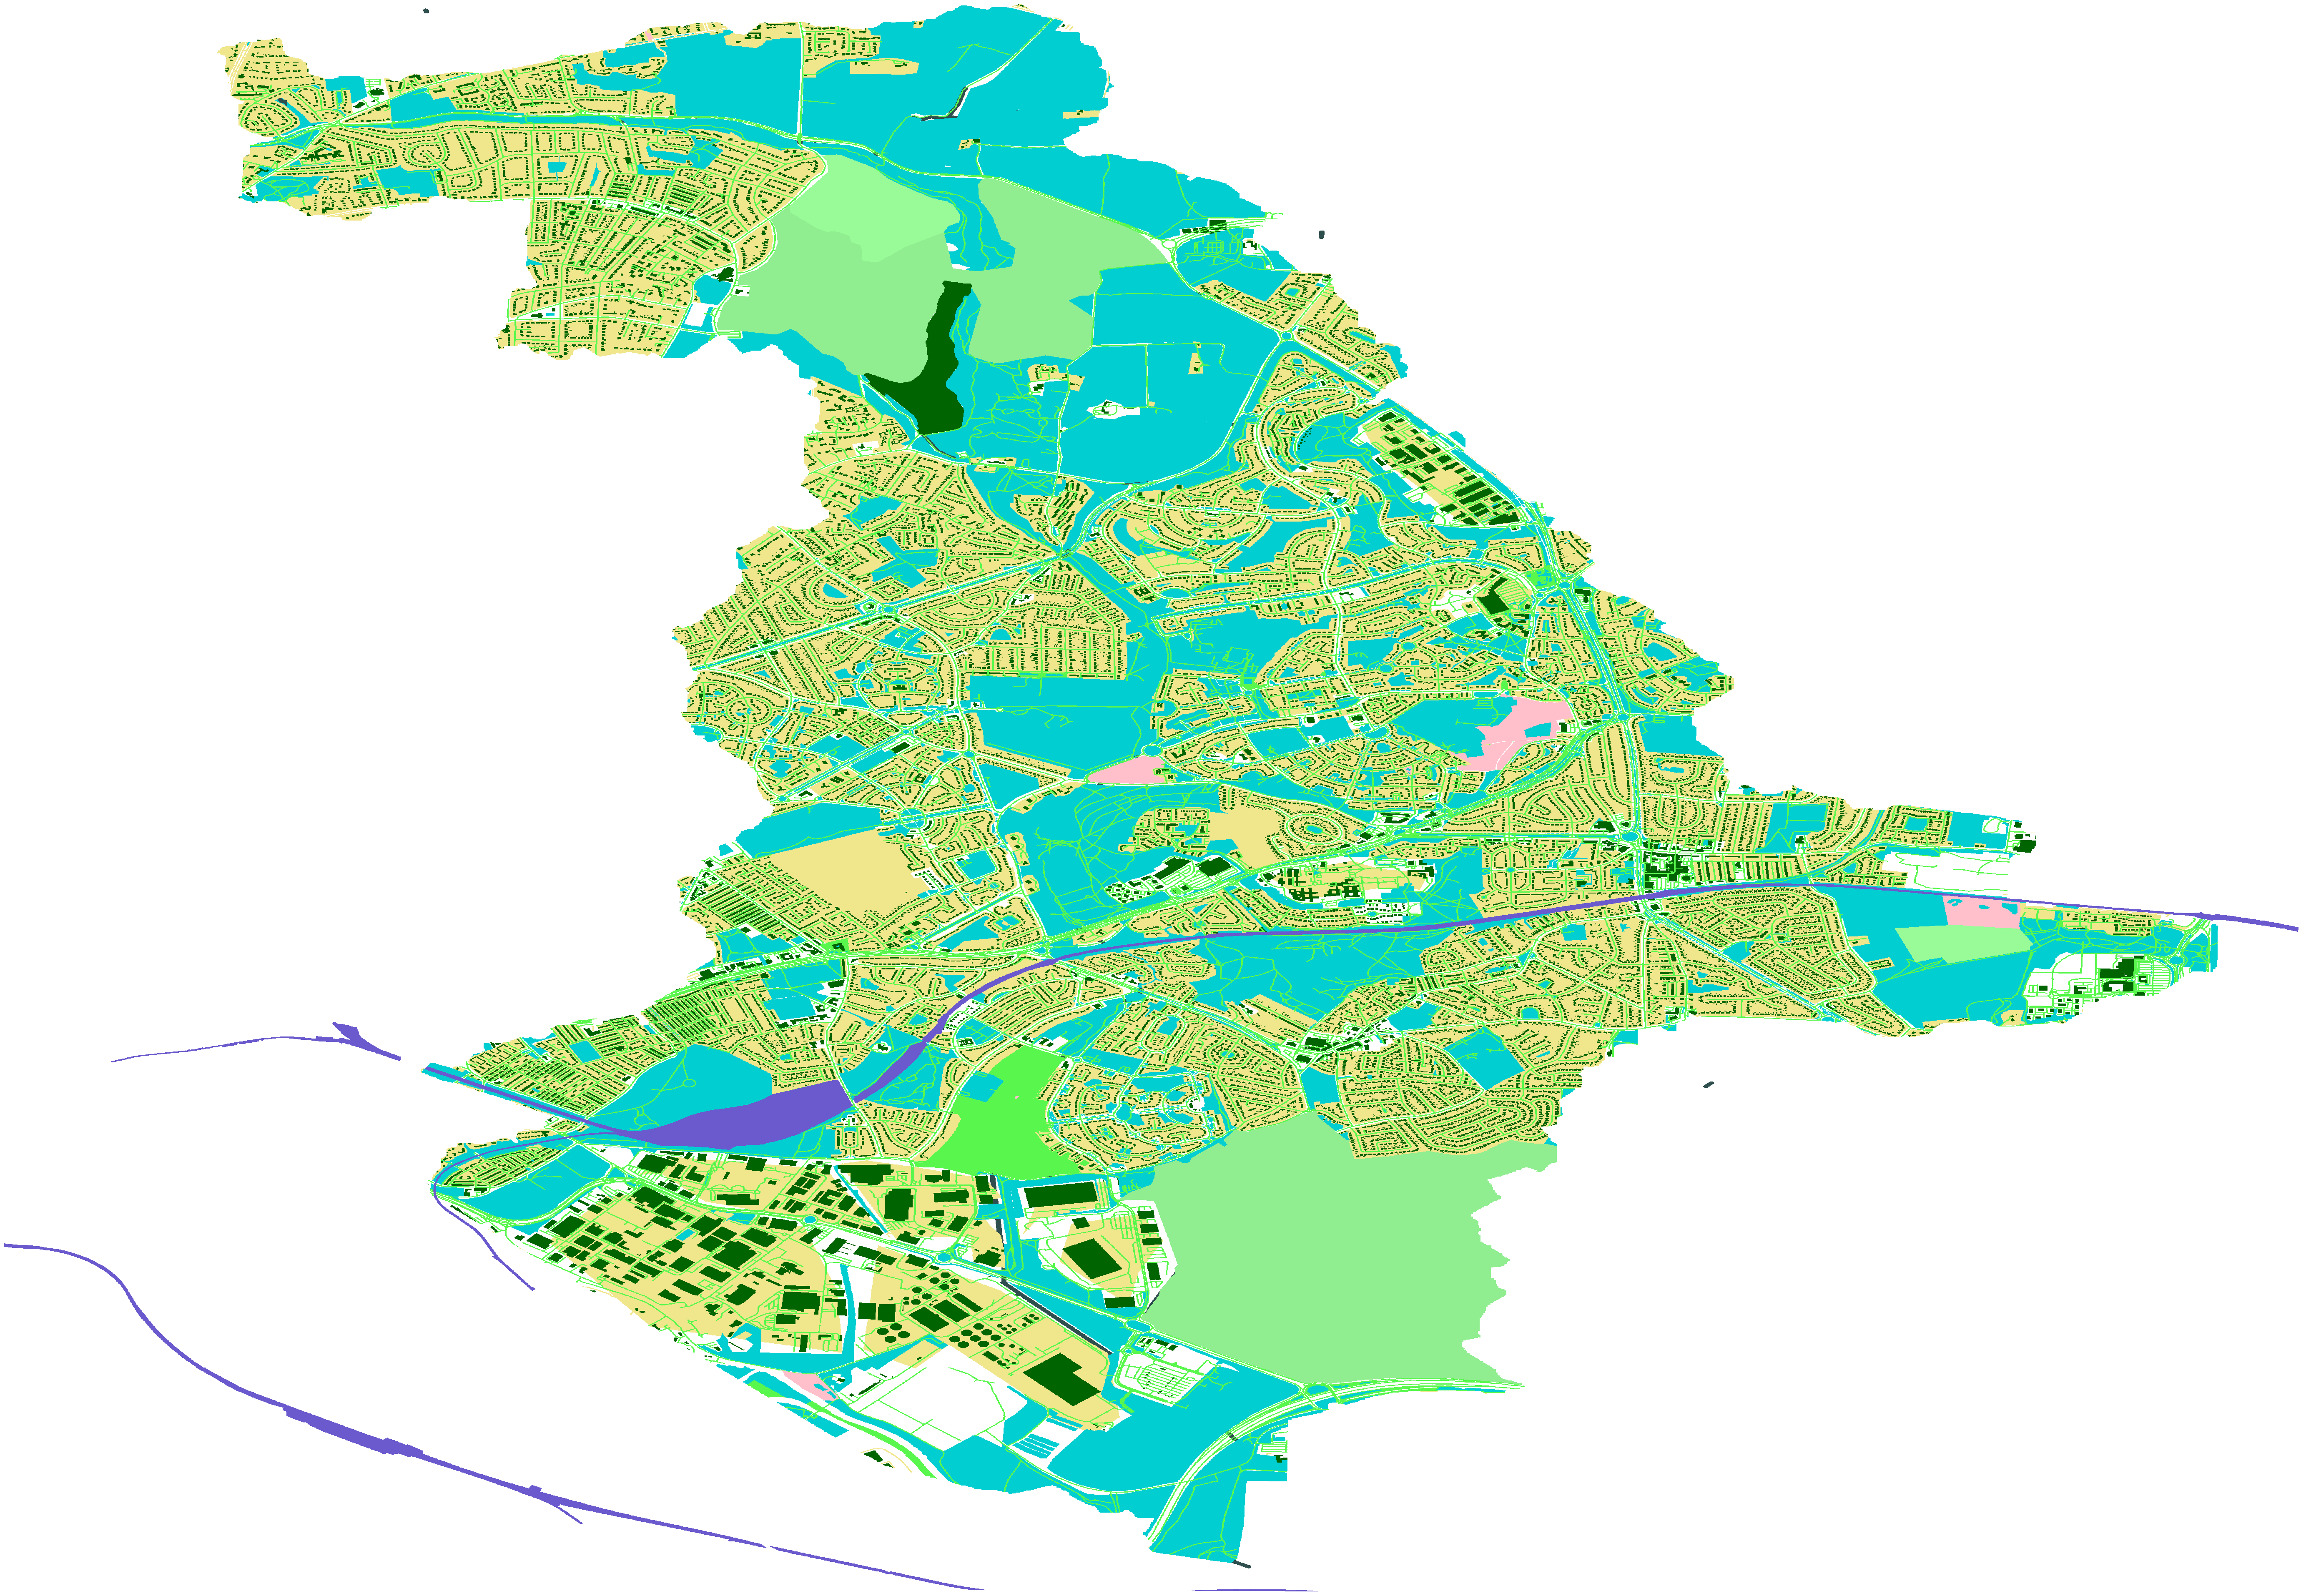
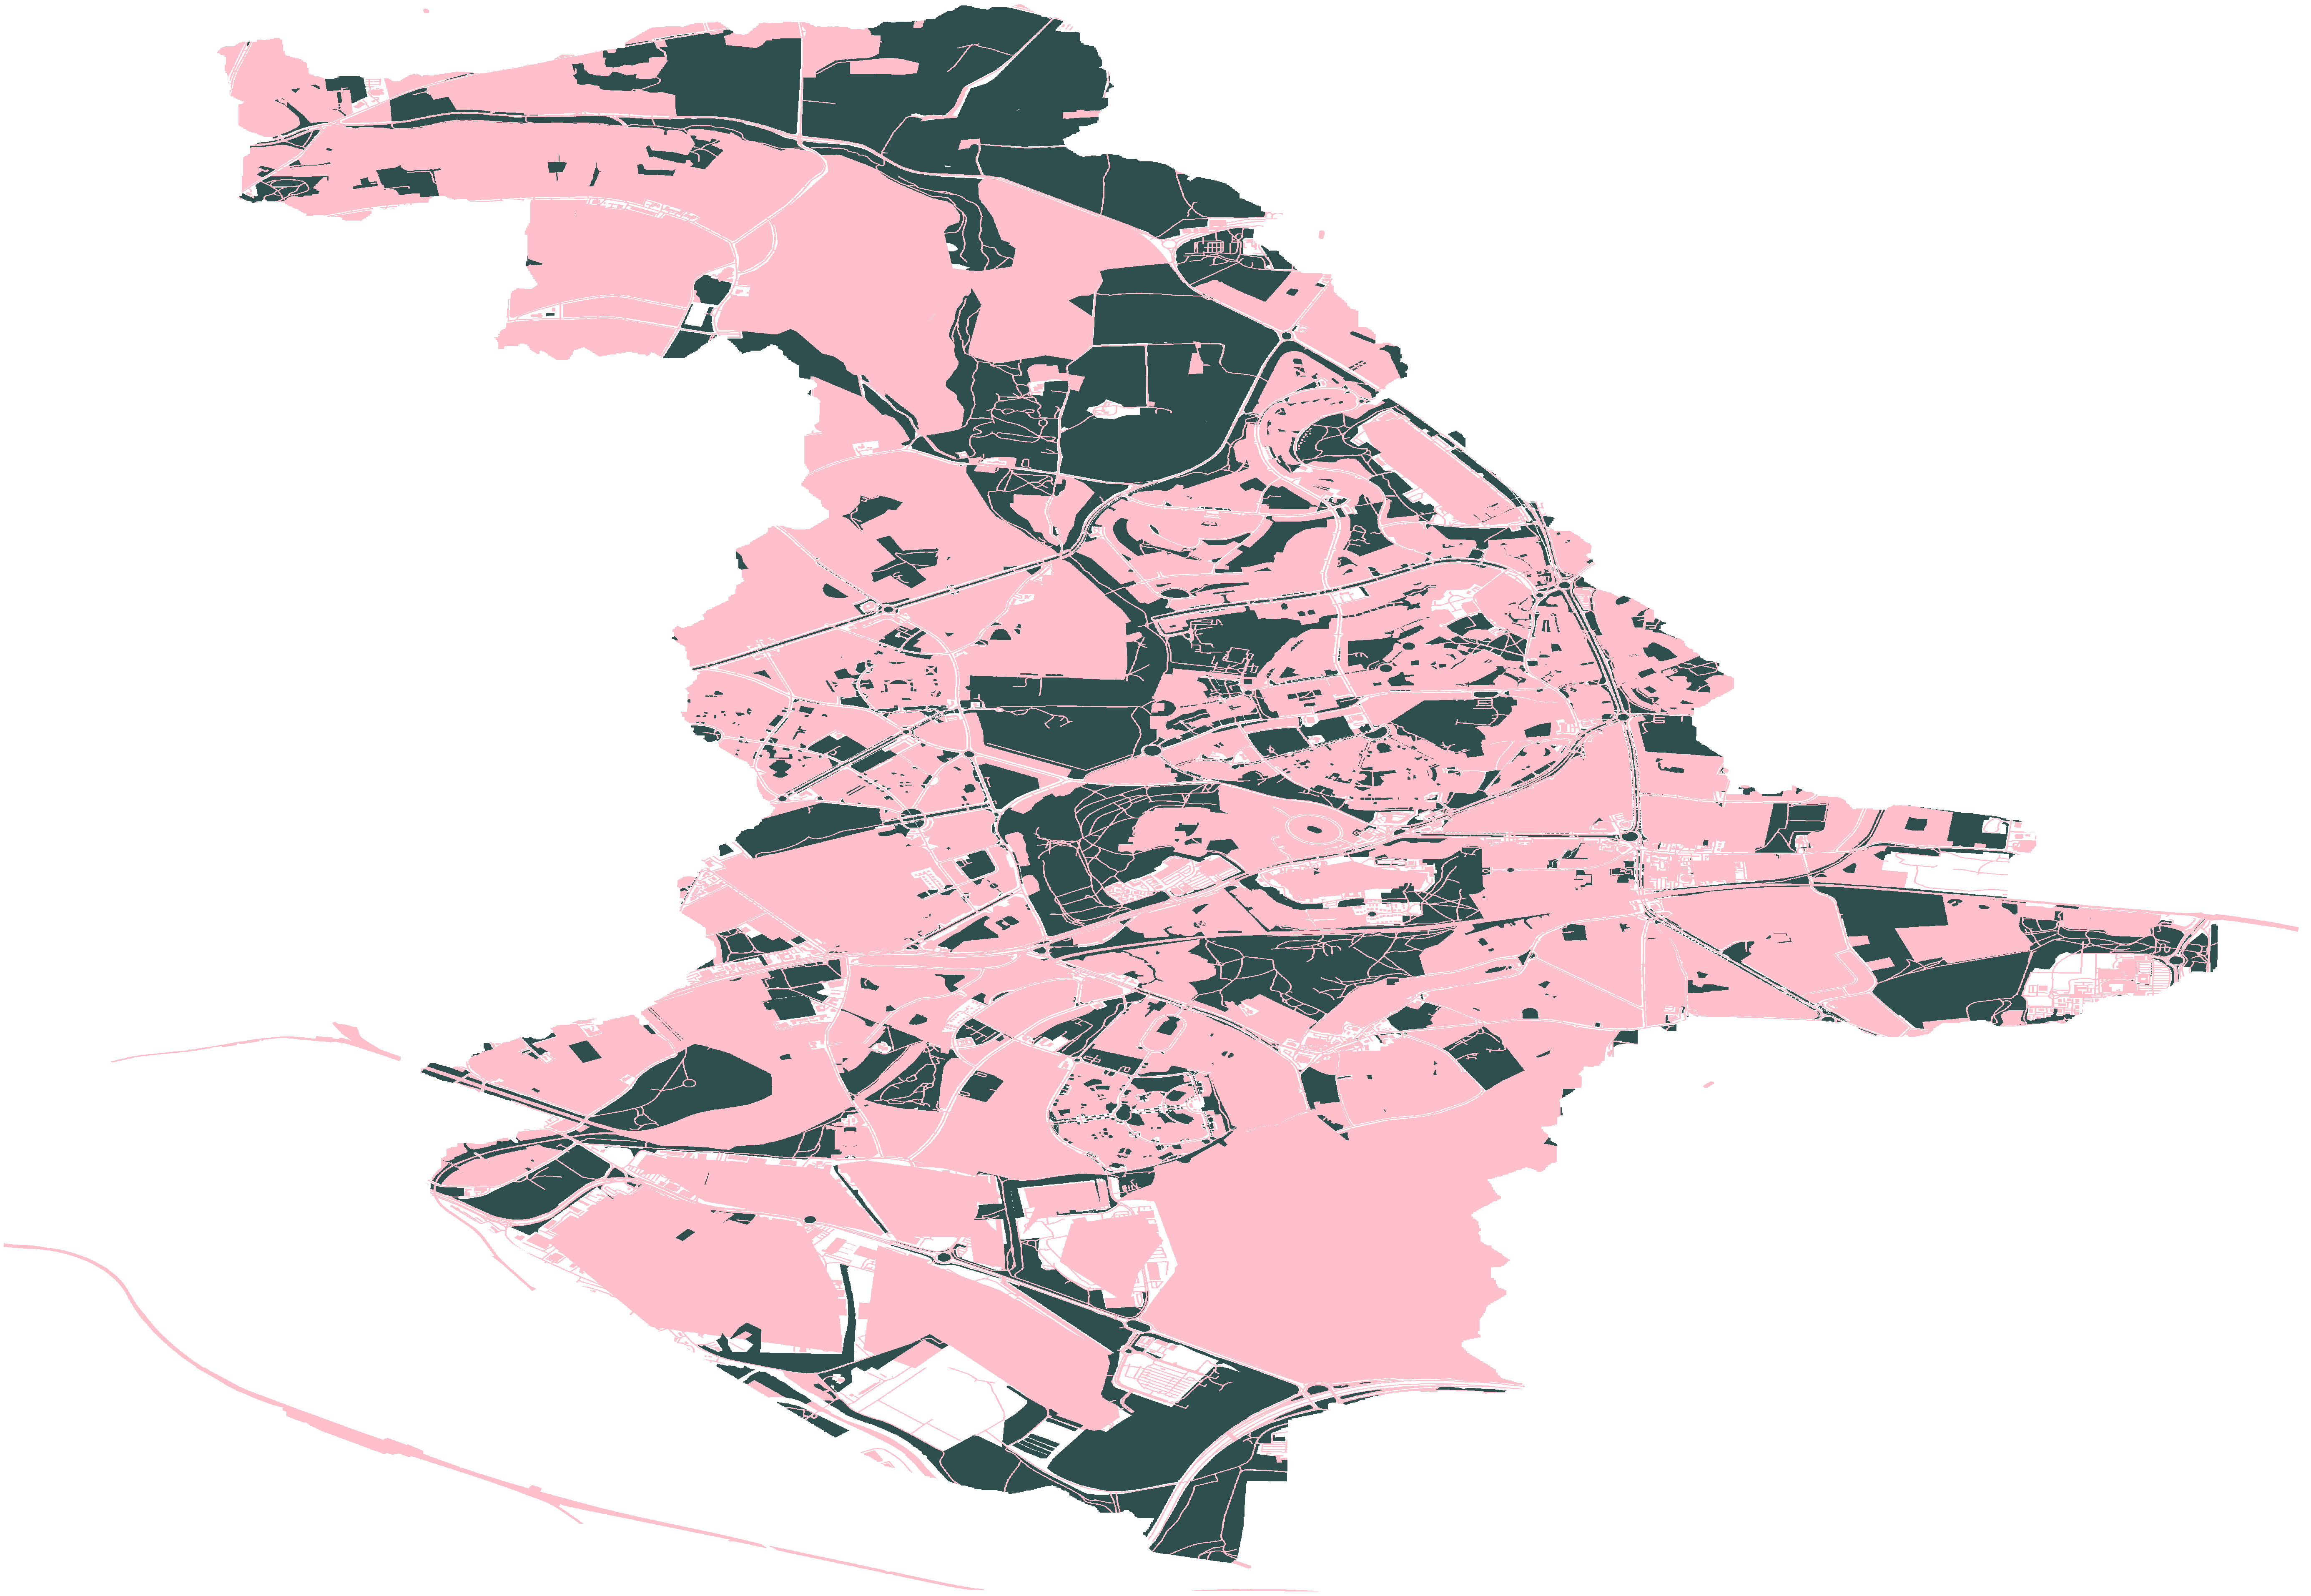

In [59]:
# Set up figure
f = folium.Figure(width=1000, height=1000)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=12).add_to(f)
folium.TileLayer(
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

if subcatchments == True:
    for subcatchment in ['LinDyke', 'Garforth_East', 'Garforth_West']:
        # Catchment boundary
        catchment_boundary_feature_group = FeatureGroup(name=subcatchment)
        catchment_boundary_feature_group.add_child(folium.GeoJson(data=boundaries_gpd_dict[subcatchment]["geometry"],
            style_function=lambda x,  fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))
        # Add to map
        mapa.add_child(catchment_boundary_feature_group)

# Add landcover data
landcover_fps = [model_directory + 'LandCoverData/LandCover_clipped.tif',
                 model_directory + 'LandCoverData/LandCover_water_classification.tif']
names = ['Original', 'Classified']
for number, landcover_fp in enumerate(landcover_fps):
    xarray_dataarray = prep_for_folium_plotting(landcover_fp)
    # Get coordinates needed in plotting
    clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
    mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
    xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
    # Apply colormap
    data  = ma.masked_invalid(xarray_dataarray.values)
    colored_data = colorize(data.data, cmap=cmap)
    
    # Add to map
    feature_group1 = FeatureGroup(name=names[number])
    feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data, [[mlat, mlon], [xlat, xlon]],
                              opacity=0.8,interactive=True, popup=names[number]))
    mapa.add_child(feature_group1)

# Add layers to map
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)

### Trim landcover data to Garforth/Kippax boundary
(we need this for filtering the ..)

In [88]:
for region_name in ['Kippax', 'Garforth', 'Kippax_West', 'Garforth_East', 'Garforth_West', 'South_Catchment', 
                    'TB_South', 'TB_North']:
    # Get region boundary
    region_boundary = boundaries_gpd_dict[region_name]
        
    # Trim land cover data
    raster = rxr.open_rasterio(model_directory + "LandCoverData/LandCover_urban_classification2.tif", masked=True).squeeze()
    raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
    
    if not os.path.exists(model_directory + "LandCoverData/{}/".format(region_name)):
        os.mkdir(model_directory + "LandCoverData/{}/".format(region_name))
    raster_clipped.rio.to_raster(model_directory + "LandCoverData/{}/LandCover_urban_classification2.tif".format(region_name))
    
    # Add to 
    values,counts = np.unique(raster_clipped.data, return_counts=True)
    if 10 not in values:
        values = np.insert(values, 0, 10, axis=0)
        counts = np.insert(counts, 0, 0, axis=0)
    df[region_name] = counts

### Plot to check trimming process

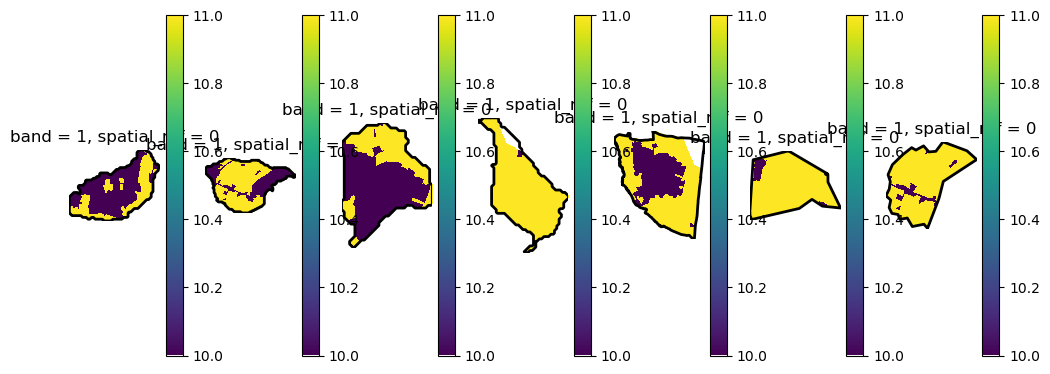

In [17]:
fig, axs =plt.subplots(ncols=7, figsize =(12,5))

for num, region_name in enumerate(['Garforth_East', 'Garforth_West', 'Kippax_West', 'South_Catchment',  'Kippax', 'TB_South', 'TB_North']):
    # Read in data
    raster = rxr.open_rasterio(model_directory + "LandCoverData/{}/LandCover_urban_classification.tif".format(region_name), masked=True).squeeze()
    raster.plot.imshow(ax=axs[num])
    boundaries_gpd_dict[region_name] .plot(ax=axs[num], facecolor="none", edgecolor= 'black', linewidth=2)
    axs[num].set_axis_off()
    axs[num].legend('', frameon=False)

### Look at proportion of each which is urban
NB: NA refers to cells which are not within the boundary of the catchment (because we initially trimmed the catchment using the bounding box of the catchment)

In [89]:
# The proportion of the area which is in within the catchment boundary
for column in df.columns[1:]:
    percent_urban = round((df[column][0]/ (df[column][1] + df[column][0]))*100,1)
    print("% of {} which is urban: ".format(column), percent_urban)

% of WholeCatchment which is urban:  4.5
% of Kippax which is urban:  1.2
% of Garforth which is urban:  7.4
% of Kippax_West which is urban:  2.6
% of Garforth_East which is urban:  6.2
% of Garforth_West which is urban:  7.8
% of South_Catchment which is urban:  0.0
% of TB_South which is urban:  0.3
% of TB_North which is urban:  1.0
